# Visualize gene expression

This notebook visualizes the gene expression data for the template and simulated experiments in order to:
1. Validate that the structure of the gene expression data and simulated data are consistent
2. To visualize the signal that is in the experiments

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

In [2]:
import os
import pandas as pd
import umap
import pickle
import glob
import seaborn as sns
from sklearn.decomposition import PCA
from keras.models import load_model
from plotnine import (ggplot,
                      labs,  
                      geom_line, 
                      geom_point,
                      geom_errorbar,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      xlim,
                      ylim,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)
from ponyo import utils
from generic_expression_patterns_modules import plot

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


## Load config parameters

In [3]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_pseudomonas_33245.tsv")
)

params = utils.read_config(config_filename)

In [4]:
# Load config params

local_dir = params['local_dir']
project_id = params['project_id']
num_simulated = params['num_simulated']

pval_name = "adj.P.Val"
logFC_name = "logFC"
run=0

# Manual settings to visualize/troubleshoot volcano plots for other datasets
# Will pull these out to archive later
"""
vae_model_dir = params['vae_model_dir']
template_filename = params['mapped_template_filename']
normalized_compendium_filename = params['normalized_compendium_filename']
scaler_filename = params['scaler_filename']
"""

# Settings for running visualization using pseudomonas config file
vae_model_dir = os.path.join(base_dir,"pseudomonas_analysis", "models", "NN_2500_30")
template_filename = params['processed_template_filename']
normalized_compendium_filename = params['normalized_compendium_filename']
scaler_filename = params['scaler_filename']

"""
# Settings for running visualization using human cancer config file
vae_model_dir = os.path.join(base_dir,"human_cancer_analysis", "models", "NN_2500_30")
template_filename = params['processed_template_filename']
normalized_compendium_filename = params['normalized_compendium_filename']
scaler_filename = params['scaler_filename']
"""
"""
# Settings for running visualization using human_general config file
vae_model_dir = os.path.join(base_dir,"human_general_analysis", "models", "NN_2500_30")
template_filename = os.path.join(base_dir,"human_general_analysis", params['processed_template_filename'])
normalized_compendium_filename = params['normalized_compendium_filename']
scaler_filename = os.path.join(base_dir, "human_general_analysis", params['scaler_filename'])
"""

'\n# Settings for running visualization using human_general config file\nvae_model_dir = os.path.join(base_dir,"human_general_analysis", "models", "NN_2500_30")\ntemplate_filename = os.path.join(base_dir,"human_general_analysis", params[\'processed_template_filename\'])\nnormalized_compendium_filename = params[\'normalized_compendium_filename\']\nscaler_filename = os.path.join(base_dir, "human_general_analysis", params[\'scaler_filename\'])\n'

## Volcano plots

In [5]:
# Check number of DEGs
template_DE_stats_filename = os.path.join(
    local_dir,
    "DE_stats",
    f"DE_stats_template_data_{project_id}_real.txt"
)

template_DE_stats = pd.read_csv(
    template_DE_stats_filename, 
    sep="\t", 
    header=0, 
    index_col=0
)

selected = template_DE_stats[(template_DE_stats[pval_name]<0.01) & (abs(template_DE_stats[logFC_name])>1)]
print(selected.shape)

(122, 6)


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


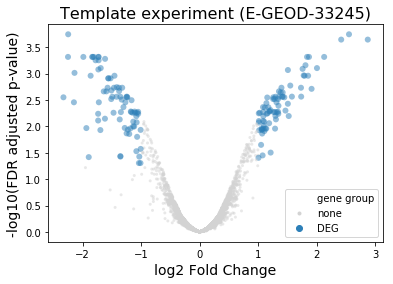

In [6]:
plot.make_volcano_plot_template(
    template_DE_stats_filename,
    project_id,
    pval_name,
    logFC_name
)

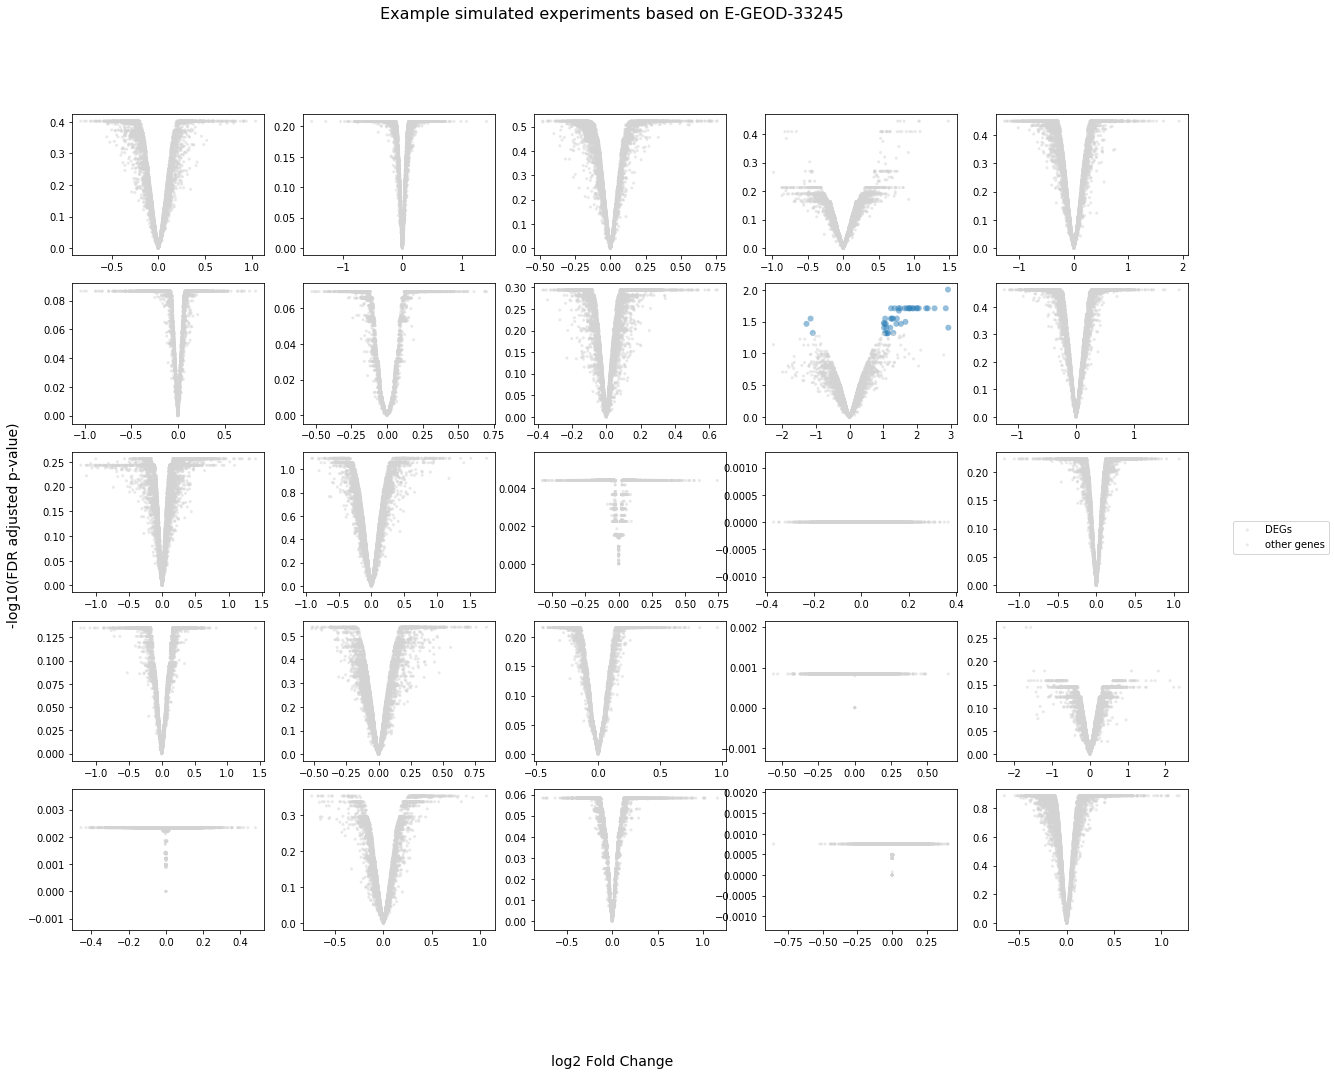

In [7]:
simulated_DE_stats_dir = os.path.join(local_dir, "DE_stats")

plot.make_volcano_plot_simulated(
    simulated_DE_stats_dir,
    project_id,
    pval_name,
    logFC_name,
    num_simulated,
    5,
    5,
    20,
    15
)

## Plot distribution of DE stats

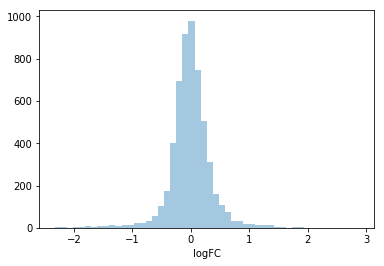

In [8]:
sns.distplot(template_DE_stats[logFC_name], kde=False)

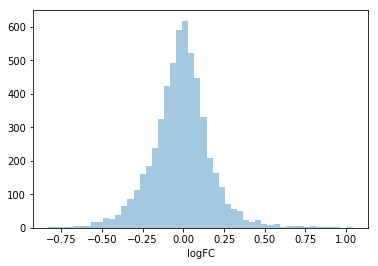

In [9]:
simulated_DE_stats_filename = os.path.join(
    simulated_DE_stats_dir,
    f"DE_stats_simulated_data_{project_id}_{run}.txt"
)

simulated_DE_stats = pd.read_csv(
    simulated_DE_stats_filename, 
    sep="\t", 
    header=0, 
    index_col=0
)

sns.distplot(simulated_DE_stats[logFC_name], kde=False)

## Plot gene expression in gene space

In [10]:
# Get decoded simulated experiment
simulated_filename = os.path.join(
    local_dir,
    "pseudo_experiment",
    f"selected_simulated_data_{project_id}_{run}.txt"
)

In [11]:
normalized_compendium_data = pd.read_csv(normalized_compendium_filename, sep="\t", index_col=0, header=0)
template_data = pd.read_csv(template_filename, sep="\t", index_col=0, header=0)
simulated_data = pd.read_csv(simulated_filename, sep="\t", index_col=0, header=0)

In [12]:
print(template_data.shape)
template_data

(4, 5549)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM822708_wtLB_A.CEL,8.725261,10.818665,8.648232,9.795110,7.222215,7.683016,7.513171,8.892119,8.388757,5.608060,...,6.992342,8.782714,8.934537,8.845352,8.419585,7.182007,7.621927,9.723923,11.453448,9.939358
GSM822709_wtLB_B.CEL,8.709181,11.074085,8.628407,9.798127,7.116004,7.861031,7.188534,8.719834,8.736998,5.640265,...,6.972987,8.880219,9.060605,8.899680,8.420385,6.203807,7.273466,9.980988,11.270670,10.005914
GSM822714_delta_crcZLB_A.CEL,8.388777,10.912782,9.056623,9.285783,7.621581,7.836151,7.790635,8.726931,8.373242,5.601331,...,7.168150,8.853644,9.160909,9.150740,8.802099,6.799052,7.547482,10.076195,11.684324,10.157211
GSM822715_delta_crcZLB_B.CEL,8.308472,10.861913,8.814091,9.657703,7.189726,7.471200,7.730470,8.753887,8.312503,5.526217,...,6.905557,8.879329,9.108007,9.026648,8.486892,6.470813,7.586620,9.425274,11.236702,9.509880


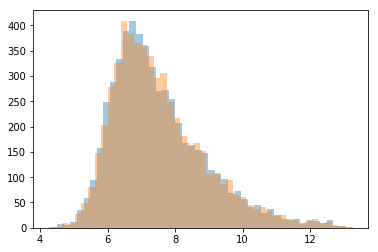

In [13]:
sns.distplot(template_data.iloc[0:2].mean(), kde=False)
sns.distplot(template_data.iloc[2:].mean(), kde=False)

In [14]:
print(simulated_data.shape)
simulated_data

(4, 5549)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM822708_wtLB_A.CEL,8.667,9.974,8.541,9.053,7.330,7.518,7.756,8.692,8.078,5.598,...,7.260,8.932,9.293,8.977,8.901,6.198,7.617,9.782,10.776,9.902
GSM822709_wtLB_B.CEL,8.850,10.204,8.655,9.511,7.420,7.486,7.727,8.848,8.321,5.586,...,6.999,9.153,9.412,8.910,8.769,5.851,7.658,9.818,10.712,9.905
GSM822714_delta_crcZLB_A.CEL,8.596,9.938,8.398,8.966,7.279,7.506,7.923,8.577,7.925,5.548,...,7.258,8.863,9.209,8.862,8.894,6.150,7.537,9.557,10.569,9.704
GSM822715_delta_crcZLB_B.CEL,8.589,9.939,8.324,8.914,7.248,7.495,8.028,8.498,7.742,5.478,...,7.239,8.781,9.106,8.781,8.882,6.104,7.487,9.309,10.389,9.574


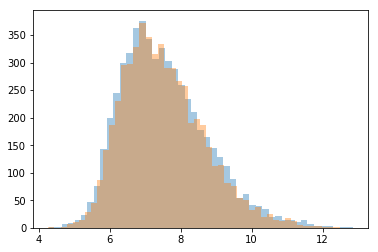

In [15]:
sns.distplot(simulated_data.iloc[0:2].mean(), kde=False)
sns.distplot(simulated_data.iloc[2:].mean(), kde=False)

In [16]:
# Normalize simulated_data
# Load pickled file
with open(scaler_filename, "rb") as scaler_fh:
    scaler = pickle.load(scaler_fh)

normalized_simulated_data = scaler.transform(simulated_data)

normalized_simulated_data = pd.DataFrame(
    normalized_simulated_data,
    columns=simulated_data.columns,
    index=simulated_data.index,
)

print(normalized_simulated_data.shape)
normalized_simulated_data.head()

(4, 5549)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM822708_wtLB_A.CEL,0.610047,0.600974,0.486580,0.614138,0.420147,0.416484,0.333792,0.553000,0.511462,0.202687,...,0.376806,0.546043,0.567653,0.535890,0.575286,0.258666,0.540995,0.533758,0.617144,0.615222
GSM822709_wtLB_B.CEL,0.656764,0.648483,0.509830,0.724747,0.441029,0.406744,0.326712,0.587593,0.564640,0.199895,...,0.327895,0.589430,0.589380,0.521492,0.541788,0.182294,0.551949,0.541118,0.606804,0.615639
GSM822714_delta_crcZLB_A.CEL,0.591921,0.593537,0.457416,0.593127,0.408314,0.412832,0.374562,0.527498,0.477981,0.191055,...,0.376431,0.532496,0.552316,0.511177,0.573509,0.248102,0.519620,0.487760,0.583700,0.587670
GSM822715_delta_crcZLB_B.CEL,0.590134,0.593744,0.442324,0.580569,0.401121,0.409484,0.400196,0.509980,0.437934,0.174770,...,0.372870,0.516398,0.533509,0.493770,0.570464,0.237978,0.506261,0.437059,0.554618,0.569580


In [17]:
"""# If template experiment included in training compendium
# Get normalized template data
sample_ids = list(template_data.index)
normalized_template_data = normalized_compendium_data.loc[sample_ids]

print(normalized_template_data.shape)
normalized_template_data.head()"""

'# If template experiment included in training compendium\n# Get normalized template data\nsample_ids = list(template_data.index)\nnormalized_template_data = normalized_compendium_data.loc[sample_ids]\n\nprint(normalized_template_data.shape)\nnormalized_template_data.head()'

In [18]:
# If template experiment NOT included in training compendium
with open(scaler_filename, "rb") as scaler_fh:
    scaler = pickle.load(scaler_fh)

normalized_template_data = scaler.transform(template_data)

normalized_template_data = pd.DataFrame(
    normalized_template_data,
    columns=template_data.columns,
    index=template_data.index,
)

In [19]:
# Label samples 
normalized_compendium_data['sample group'] = "compendium"
normalized_template_data['sample group'] = "template"
normalized_simulated_data['sample group'] = "simulated"

In [20]:
normalized_all_data = pd.concat([normalized_template_data,
                             normalized_simulated_data,
                             normalized_compendium_data
])

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


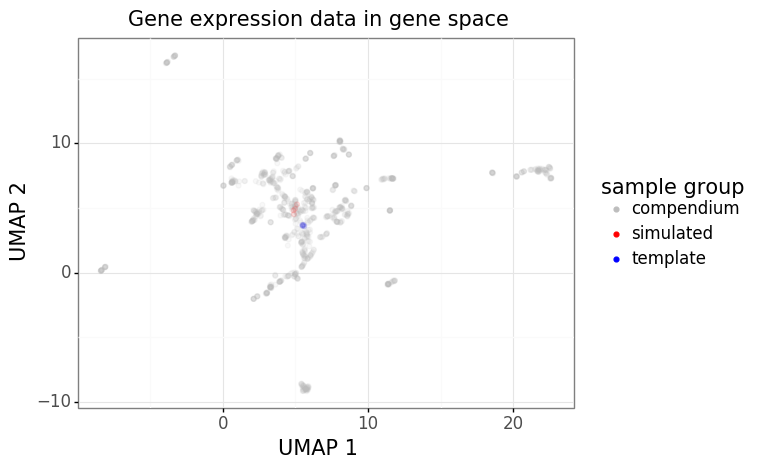

<ggplot: (8727942914737)>


In [21]:
# Plot

# Drop label column
normalized_all_data_numeric = normalized_all_data.drop(['sample group'], axis=1)

model = umap.UMAP(random_state=1).fit(normalized_all_data_numeric)

normalized_all_data_UMAPencoded = model.transform(normalized_all_data_numeric)
normalized_all_data_UMAPencoded_df = pd.DataFrame(data=normalized_all_data_UMAPencoded,
                                         index=normalized_all_data.index,
                                         columns=['1','2'])

# Add back label column
normalized_all_data_UMAPencoded_df['sample group'] = normalized_all_data['sample group']

# Plot
fig = ggplot(normalized_all_data_UMAPencoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='sample group'), alpha=0.1)
fig += labs(x ='UMAP 1',
            y = 'UMAP 2',
            title = 'Gene expression data in gene space')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += scale_color_manual(['#bdbdbd', 'red', 'blue'])
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))

print(fig)

## Plot gene expression data in latent space

In [22]:
# Model files
model_encoder_filename = glob.glob(os.path.join(vae_model_dir, "*_encoder_model.h5"))[0]
weights_encoder_filename = glob.glob(os.path.join(vae_model_dir, "*_encoder_weights.h5"))[0]
model_decoder_filename = glob.glob(os.path.join(vae_model_dir, "*_decoder_model.h5"))[0]
weights_decoder_filename = glob.glob(os.path.join(vae_model_dir, "*_decoder_weights.h5"))[0]

In [23]:
# Load saved models
loaded_model = load_model(model_encoder_filename, compile=False)
loaded_decode_model = load_model(model_decoder_filename, compile=False)

loaded_model.load_weights(weights_encoder_filename)
loaded_decode_model.load_weights(weights_decoder_filename)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [24]:
# PCA model
pca = PCA(n_components=2)

In [25]:
# Encode compendium
normalized_compendium = normalized_compendium_data.drop(['sample group'], axis=1)
compendium_encoded = loaded_model.predict_on_batch(normalized_compendium)

compendium_encoded_df = pd.DataFrame(data=compendium_encoded, 
                                     index=normalized_compendium.index)

# Get and save PCA model
model2 = pca.fit(compendium_encoded_df)

compendium_PCAencoded = model2.transform(compendium_encoded_df)

compendium_PCAencoded_df = pd.DataFrame(data=compendium_PCAencoded,
                                         index=compendium_encoded_df.index,
                                         columns=['1','2'])

# Add label
compendium_PCAencoded_df['sample group'] = 'compendium'

In [26]:
# Encode template experiment
normalized_template_data = normalized_template_data.drop(['sample group'], axis=1)

template_encoded = loaded_model.predict_on_batch(normalized_template_data)
template_encoded_df = pd.DataFrame(data=template_encoded,
                                   index=normalized_template_data.index)

template_PCAencoded = model2.transform(template_encoded_df)

template_PCAencoded_df = pd.DataFrame(data=template_PCAencoded,
                                         index=template_encoded_df.index,
                                         columns=['1','2'])

# Add back label column
template_PCAencoded_df['sample group'] = 'template'

In [27]:
# Use stored encoded simulated data
# Note: We cannot encode the decoded simulated experiment since we are not using tied weights
# Re-encoded the decoded simulated experiment will not yield a linear latent space shift
encoded_simulated_filename = os.path.join(
    local_dir,
    "pseudo_experiment",
    f"selected_simulated_encoded_data_{project_id}_{run}.txt"
)

simulated_encoded_df = pd.read_csv(encoded_simulated_filename,header=0, sep='\t', index_col=0)

sample_ids = list(template_data.index)
simulated_encoded_df = simulated_encoded_df.loc[sample_ids]

simulated_PCAencoded = model2.transform(simulated_encoded_df)

simulated_PCAencoded_df = pd.DataFrame(data=simulated_PCAencoded,
                                         index=simulated_encoded_df.index,
                                         columns=['1','2'])

# Add back label column
simulated_PCAencoded_df['sample group'] = 'simulated'

In [28]:
# Concatenate dataframes
combined_PCAencoded_df = pd.concat([compendium_PCAencoded_df, 
                                    template_PCAencoded_df,
                                    simulated_PCAencoded_df])

print(combined_PCAencoded_df.shape)
combined_PCAencoded_df.head()

(958, 3)


,1,2,sample group
05_PA14000-4-2_5-10-07_S2.CEL,7.634135,-0.692191,compendium
54375-4-05.CEL,4.224761,2.764038,compendium
AKGlu_plus_nt_7-8-09_s1.CEL,4.969287,0.088333,compendium
anaerobic_NO3_1.CEL,-6.150396,3.096243,compendium
anaerobic_NO3_2.CEL,-5.901340,3.416079,compendium


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


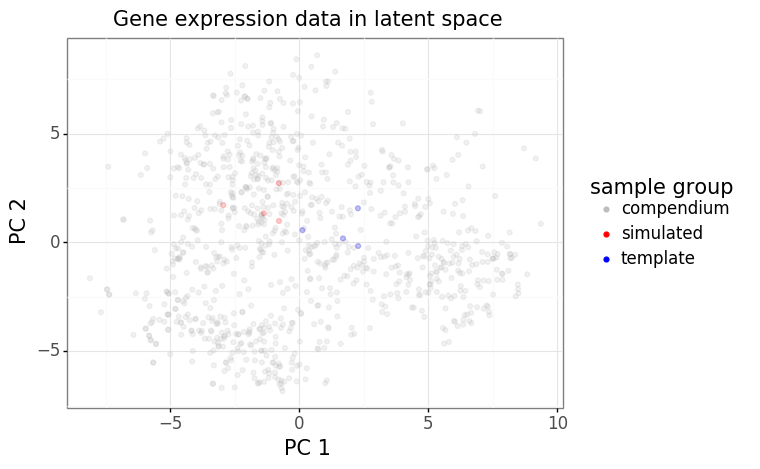

<ggplot: (8727934603937)>


In [29]:
# Plot
fig = ggplot(combined_PCAencoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='sample group'), alpha=0.2)
fig += labs(x ='PC 1',
            y = 'PC 2',
            title = 'Gene expression data in latent space')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += scale_color_manual(['#bdbdbd', 'red', 'blue'])
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))

print(fig)